In [1]:
%load_ext line_profiler

In [2]:
import numpy as np
import cv2
from scipy.spatial import Delaunay
import knn

import matplotlib.pyplot as plt

In [3]:
DEFINED = 0
UNDEFINED = 255

origin = (15, 15)
mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)
print(mask.dtype)

uint8


In [4]:
def display_neighbors(mask: np.ndarray, origin: tuple, neighbors: list[tuple], figsize=(6, 6)):
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    axis.imshow(mask, cmap="Greys", alpha=0.5)
    axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    axis.scatter(y=[n[0] for n in neighbors], x=[n[1] for n in neighbors], c="m")
    
    axis.set_xticks([])
    axis.set_yticks([])

    plt.show()

def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)

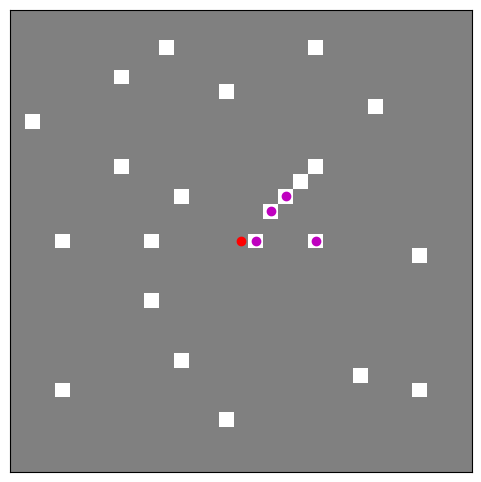

In [5]:
def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = set()
    origin_y, origin_x = origin
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    for distance in range(1, furthest_pixel):
        discretization = np.linspace(0, 2, int(4 * np.pi * distance + 1)) * np.pi
        Y = np.round(distance * np.cos(discretization) + origin_y).astype(int)
        X = np.round(distance * np.sin(discretization) + origin_x).astype(int)

        for y, x in zip(Y, X):
            if 0 <= y < height and 0 <= x < width and mask[y, x] == DEFINED:
                neighbors.add((y, x))
                if len(neighbors) == k:
                    return list(neighbors)

    return list(neighbors)

neighbors = nn_circle(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [6]:
%lprun -f nn_circle nn_circle(mask, origin, 4)

Timer unit: 1e-09 s

Total time: 0.00102507 s
File: /tmp/ipykernel_13017/3619931796.py
Function: nn_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1       1123.0   1123.0      0.1      neighbors = set()
     3         1        370.0    370.0      0.0      origin_y, origin_x = origin
     4         1       1873.0   1873.0      0.2      height, width = mask.shape
     5                                           
     6         1      45746.0  45746.0      4.5      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     7                                           
     8         5       2373.0    474.6      0.2      for distance in range(1, furthest_pixel):
     9         5     263991.0

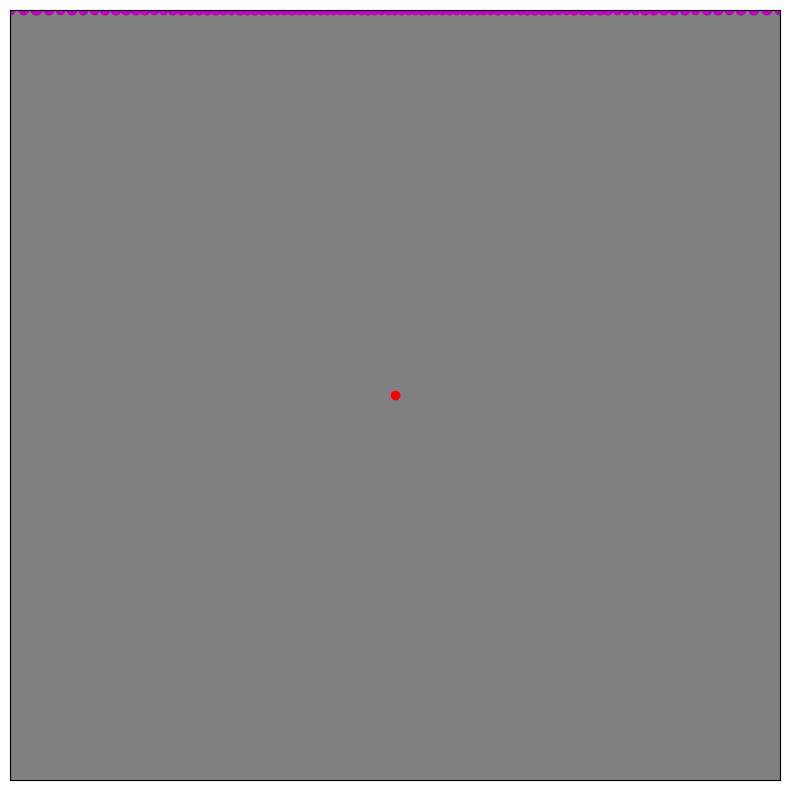

In [7]:
image = np.full((1001, 1001), UNDEFINED)
image[0, :] = DEFINED
o = (500, 500)

neighbors = knn.nn_circular_native(image, o, 9999)
display_neighbors(image, o, neighbors, figsize=(10, 10))

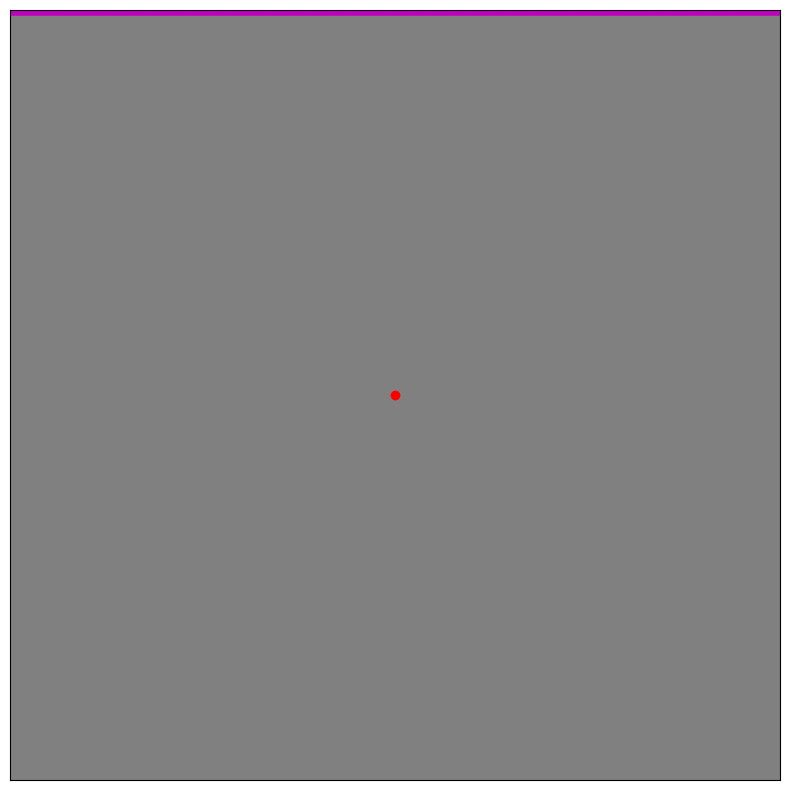

In [8]:
neighbors = knn.nn_circular_native_2(image, o, 9999)
display_neighbors(image, o, neighbors, figsize=(10, 10))

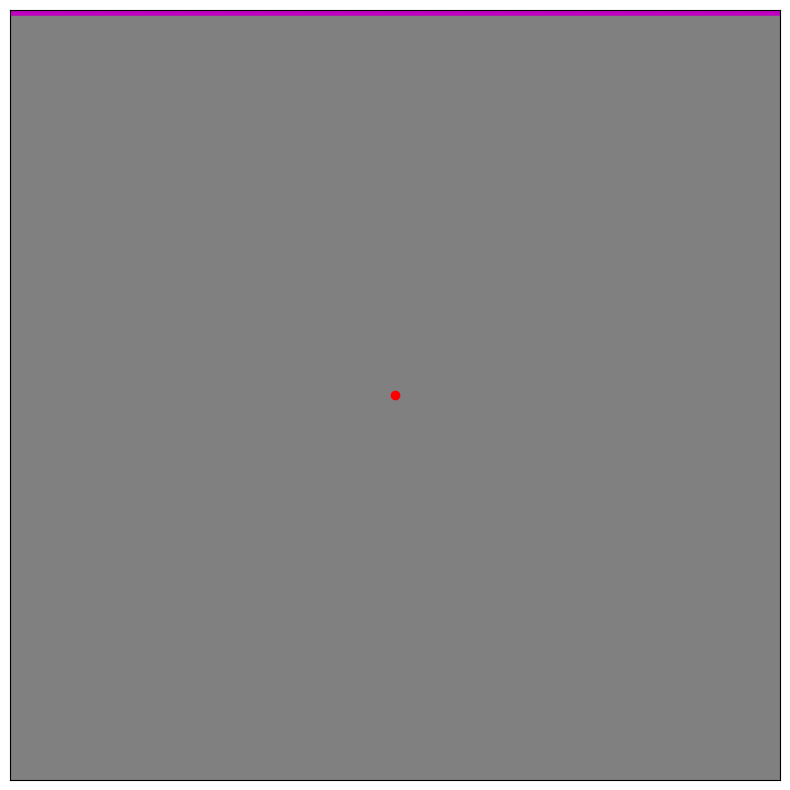

In [9]:
neighbors = knn.nn_circular_native_3(image, o, 9999)
display_neighbors(image, o, neighbors, figsize=(10, 10))

In [10]:
np.random.seed(42)

In [11]:
def generate_mask(shape=(1001, 1001), fillfactor=0.01):
    mask = np.random.rand(shape[0] * shape[1]).reshape(shape)
    mask = np.where(mask < fillfactor, DEFINED, UNDEFINED)
    mask = mask.astype(np.uint8)
    origin = (shape[0] // 2, shape[1] // 2)
    mask[origin[0], origin[1]] = UNDEFINED
    return mask, origin

In [12]:
mask, origin = generate_mask((501, 501))

%timeit -n 100 -r 10 nn_circle(mask, origin, 10)
%timeit -n 100 -r 10 knn.nn_circular_native_2(mask, origin, 10)

3.48 ms ± 41.7 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
18.1 µs ± 457 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)
22 µs ± 48.2 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [13]:
mask, origin = generate_mask((1001, 1001))

%timeit -n 100 -r 10 nn_circle(mask, origin, 10)
%timeit -n 100 -r 10 knn.nn_circular_native_2(mask, origin, 10)

3.9 ms ± 14.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
19.9 µs ± 394 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)
34.6 µs ± 257 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [14]:
mask, origin = generate_mask((5001, 5001))

%timeit -n 100 -r 10 nn_circle(mask, origin, 10)
%timeit -n 100 -r 10 knn.nn_circular_native_2(mask, origin, 10)

: 

In [16]:
mask, origin = generate_mask((10001, 10001), fillfactor=0.001)

%timeit -n 100 -r 10 nn_circle(mask, origin, 10)
%timeit -n 100 -r 10 knn.nn_circular_native_2(mask, origin, 10)

40 ms ± 137 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
200 µs ± 545 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [18]:
200 / (40 * 1000) * 100

0.5